In [10]:
import sys
sys.path.append("../")
from clapton.clapton import claptonize
from clapton.ansatzes import * 
from clapton.clifford import ParametrizedCliffordCircuit
import numpy as np
import stim 
import pandas as pd
from qiskit import QuantumCircuit
from qiskit.converters import circuit_to_dag, dag_to_circuit
from qiskit_qec.utils.stim_tools import get_stim_circuits
from qiskit_research.utils.convenience import *
import random

In [11]:
paulis = ["XXI", "IXX", "YYI", "IYY", "ZZI", "IZZ"]
coeffs = np.random.random(len(paulis))

from clapton.depolarization import GateGeneralDepolarizationModel #TODO: check this out 


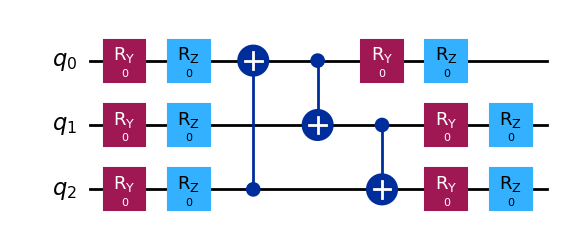

In [12]:
def circular_ansatz(N, reps=1, fix_2q=False):
    pcirc = QuantumCircuit(N)
    for _ in range(reps):
        for i in range(N):
            pcirc.ry(0,i)
        for i in range(N):
            pcirc.rz(0,i)
        for i in range(N):
            control = (i-1) % N
            target = i
            if fix_2q:
                pcirc.cx(control, target).fix(1)
            else:
                pcirc.cx(control, target)
    for i in range(N):
        pcirc.ry(0,i)
    for i in range(N):
        pcirc.rz(0,i)
    return pcirc

qc=circular_ansatz(3)
qc.draw(output='mpl')

## Altering the Ansatz itself

In [14]:
rng = np.random.default_rng()

TWIRL_GATES_CX = (
        (('I', 'I'), ('I', 'I')),
        (('I', 'X'), ('I', 'X')),
        (('I', 'Y'), ('Z', 'Y')),
        (('I', 'Z'), ('Z', 'Z')),
        (('X', 'I'), ('X', 'X')),
        (('X', 'X'), ('X', 'I')),
        (('X', 'Y'), ('Y', 'Z')),
        (('X', 'Z'), ('Y', 'Y')),
        (('Y', 'I'), ('Y', 'X')),
        (('Y', 'X'), ('Y', 'I')),
        (('Y', 'Y'), ('X', 'Z')),
        (('Y', 'Z'), ('X', 'Y')),
        (('Z', 'I'), ('Z', 'I')),
        (('Z', 'X'), ('Z', 'X')),
        (('Z', 'Y'), ('I', 'Y')),
        (('Z', 'Z'), ('I', 'Z')),
    )

pauli_twirl_dict = {"I":0,"X":1,"Y":2,"Z":3}

def twirled_circular_ansatz(N, reps=1, fix_2q=False):
    pcirc = ParametrizedCliffordCircuit()
    for _ in range(reps):
        for i in range(N):
            pcirc.RY(i)
        for i in range(N):
            pcirc.RZ(i)
        for i in range(N):
            control = (i-1) % N
            target = i
            if fix_2q:
                
                (before0, before1), (after0, after1) = TWIRL_GATES_CX[
                    rng.integers(len(TWIRL_GATES_CX))]

                pcirc.PauliTwirl(control).fix(pauli_twirl_dict[before0])
                pcirc.PauliTwirl(control).fix(pauli_twirl_dict[before1])
                pcirc.Q2(control, target).fix(1)
                pcirc.PauliTwirl(target).fix(pauli_twirl_dict[after0])
                pcirc.PauliTwirl(target).fix(pauli_twirl_dict[after1])
            else:
                pcirc.Q2(control, target)
    for i in range(N):
        pcirc.RY(i)
    for i in range(N):
        pcirc.RZ(i)

    
    return pcirc

pauli_twirl_list = [twirled_circular_ansatz(N=len(paulis[0]), reps=1, fix_2q=True) for _ in range(10)]


In [15]:
twirl_ansatz = twirled_circular_ansatz(N=len(paulis[0]), reps=1, fix_2q=True)

# let's add a noise model where we specify global 1q and 2q gate errors
nm = GateGeneralDepolarizationModel(p1=0.005, p2=0.02)
twirl_ansatz.add_depolarization_model(nm)


In [16]:
twirl_ansatz.read()

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [17]:
twirl_ansatz.stim_circuit().diagram()

q0: -I-DEPOLARIZE1(0.005)--------------------I------------------DEPOLARIZE1(0.005)---------------------------------------------------------------------------------X-DEPOLARIZE2(0.02)-I-DEPOLARIZE1(0.005)-Z-DEPOLARIZE1(0.005)-Y-DEPOLARIZE1(0.005)-X-DEPOLARIZE1(0.005)-@-DEPOLARIZE2(0.02)--------------------------------------------------------------------------------------------------------------------------------I------------------DEPOLARIZE1(0.005)--------------------I------------------DEPOLARIZE1(0.005)---------------------------------------
                                                                                                                                                                   | |                                                                                                     | |
q1: ---I------------------DEPOLARIZE1(0.005)--------------------I------------------DEPOLARIZE1(0.005)--------------------------------------------------------------|-|-----------------------------------------------------------------------------------------------------X-DEPOLARIZE2(0.02)-Y-DEPOLARIZE1(0.005)-I-DEPOLARIZE1(0.005)-Y-DEPOLARIZE1(0.005)-Z-DEPOLARIZE1(0.005)-@-DEPOLARIZE2(0.02)-------------------------------------------I------------------DEPOLARIZE1(0.005)--------------------I------------------DEPOLARIZE1(0.005)--------------------
                                                                                                                                                                   | |                                                                                                                                                                                                             | |
q2: ----------------------I------------------DEPOLARIZE1(0.005)--------------------I------------------DEPOLARIZE1(0.005)-Z-DEPOLARIZE1(0.005)-Z-DEPOLARIZE1(0.005)-@-DEPOLARIZE2(0.02)---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------X-DEPOLARIZE2(0.02)-X-DEPOLARIZE1(0.005)-Y-DEPOLARIZE1(0.005)--------------------I------------------DEPOLARIZE1(0.005)--------------------I------------------DEPOLARIZE1(0.005)-

In [18]:
ks_best, energy_noisy, energy_noiseless = claptonize(
    paulis,
    coeffs,
    twirl_ansatz,
    n_proc=4,           # total number of processes in parallel
    n_starts=4,         # number of random genetic algorithm starts in parallel
    n_rounds=1,         # number of budget rounds, if None it will terminate itself
    callback=print,     # callback for internal parameter (#iteration, energies, ks) processing
    budget=20,
    pauli_twirl_list=None                        # budget per genetic algorithm instance
)

STARTING ROUND 0


started GA at id 1 with 1 procs



/home/dbharadwaj/anaconda3/envs/clapton/lib/python3.10/site-packages/pygad/pygad.py:1139: UserWarning: The 'delay_after_gen' parameter is deprecated starting from PyGAD 3.3.0. To delay or pause the evolution after each generation, assign a callback function/method to the 'on_generation' parameter to adds some time delay.
  warnings.warn("The 'delay_after_gen' parameter is deprecated starting from PyGAD 3.3.0. To delay or pause the evolution after each generation, assign a callback function/method to the 'on_generation' parameter to adds some time delay.")


started GA at id None with 1 procs

started GA at id 2 with 1 procs


/home/dbharadwaj/anaconda3/envs/clapton/lib/python3.10/site-packages/pygad/pygad.py:1139: UserWarning: The 'delay_after_gen' parameter is deprecated starting from PyGAD 3.3.0. To delay or pause the evolution after each generation, assign a callback function/method to the 'on_generation' parameter to adds some time delay.
  warnings.warn("The 'delay_after_gen' parameter is deprecated starting from PyGAD 3.3.0. To delay or pause the evolution after each generation, assign a callback function/method to the 'on_generation' parameter to adds some time delay.")


started GA at id 3 with 1 procs



/home/dbharadwaj/anaconda3/envs/clapton/lib/python3.10/site-packages/pygad/pygad.py:1139: UserWarning: The 'delay_after_gen' parameter is deprecated starting from PyGAD 3.3.0. To delay or pause the evolution after each generation, assign a callback function/method to the 'on_generation' parameter to adds some time delay.
  warnings.warn("The 'delay_after_gen' parameter is deprecated starting from PyGAD 3.3.0. To delay or pause the evolution after each generation, assign a callback function/method to the 'on_generation' parameter to adds some time delay.")


/home/dbharadwaj/anaconda3/envs/clapton/lib/python3.10/site-packages/pygad/pygad.py:1139: UserWarning: The 'delay_after_gen' parameter is deprecated starting from PyGAD 3.3.0. To delay or pause the evolution after each generation, assign a callback function/method to the 'on_generation' parameter to adds some time delay.
  warnings.warn("The 'delay_after_gen' parameter is deprecated starting from PyGAD 3.3.0. To delay or pause the evolution after each generation, assign a callback function/method to the 'on_generation' parameter to adds some time delay.")


[0, array([-3.17403347, -1.44535203, -1.72868144,  0.        ]), array([0, 2, 1, 1, 3, 0, 2, 2, 3, 0, 0, 1], dtype=object)]
[0, array([-2.48767971, -1.15690003, -1.33077968,  0.        ]), array([2, 0, 0, 2, 3, 2, 1, 3, 3, 1, 1, 3], dtype=object)]
[0, array([-1.93030717, -0.89305814, -1.03724903,  0.        ]), array([2, 3, 0, 0, 0, 3, 0, 0, 2, 3, 1, 3], dtype=object)][0, array([-1.95630483, -0.9190558 , -1.03724903,  0.        ]), array([0, 3, 2, 1, 2, 0, 1, 3, 1, 3, 1, 3], dtype=object)]

[1, array([-3.17174368, -1.44306224, -1.72868144,  0.        ]), array([1, 0, 3, 0, 1, 0, 0, 2, 3, 1, 1, 1], dtype=object)]
[1, array([-3.19970116, -1.47101972, -1.72868144,  0.        ]), array([1, 0, 1, 0, 1, 2, 1, 3, 3, 2, 2, 1], dtype=object)]
[1, array([-3.15999823, -1.43131679, -1.72868144,  0.        ]), array([0, 0, 1, 1, 2, 1, 0, 2, 3, 3, 2, 1], dtype=object)]
[1, array([-2.45060035, -1.11982067, -1.33077968,  0.        ]), array([2, 3, 3, 3, 0, 2, 0, 2, 2, 3, 1, 1], dtype=object)]
[2, arra

In [19]:
ks_best

[3, 2, 1, 2, 0, 2, 3, 1, 2, 2, 0, 0]

In [20]:
energy_noisy, energy_noiseless

(-1.4735414345807516, -1.7286814363634875)

In [21]:
# differrence
np.abs(energy_noisy-energy_noiseless)

0.2551400017827359

In [22]:
# the corresponding circuit is
twirl_ansatz.assign(ks_best)
twirl_ansatz.snapshot_noiseless().circ_snapshot_noiseless.diagram()

q0: -SQRT_Y_DAG-Z-----X-I-Z-Y-X-@-------------SQRT_Y_DAG-Z---
                      |         |
q1: -Y----------I-----|---------X-Y-I-Y-Z-@---SQRT_Y-----I---
                      |                   |
q2: -SQRT_Y-----Z-Z-Z-@-------------------X-X-Y----------Y-I-

In [23]:
import stim
import numpy as np

# Define the number of shots
shots = 1024

# Create a new Stim circuit
circuit = stim.Circuit()

# Prepare a GHZ state: |000> + |111>
# Start with three qubits in the |0> state by default
circuit.append_operation("H", [0])       # Apply H to qubit 0
circuit.append_operation("CNOT", [0, 1]) # Apply CNOT from qubit 0 to qubit 1
circuit.append_operation("CNOT", [1, 2]) # Apply CNOT from qubit 1 to qubit 2

# Measure each qubit in the computational basis
circuit.append_operation("M", [0, 1, 2])

# Compile a sampler for the circuit
sampler = circuit.compile_sampler()

# Run the experiment and sample results
results = sampler.sample(shots=shots)

# Convert results to a NumPy array for analysis
results_array = np.array(results)

# Display some information about the results
print("Sampled results (first 10 shots):")
print(results_array[:10])  # Print the first 10 shots for inspection

# Analyze counts of |000> and |111>
count_000 = np.sum(np.all(results_array == [0, 0, 0], axis=1))
count_111 = np.sum(np.all(results_array == [1, 1, 1], axis=1))

print(f"\nCounts:")
print(f" |000⟩ state: {count_000}")
print(f" |111⟩ state: {count_111}")
print(f" Other states: {shots - count_000 - count_111}")


Sampled results (first 10 shots):
[[ True  True  True]
 [ True  True  True]
 [ True  True  True]
 [False False False]
 [ True  True  True]
 [ True  True  True]
 [False False False]
 [False False False]
 [ True  True  True]
 [ True  True  True]]

Counts:
 |000⟩ state: 530
 |111⟩ state: 494
 Other states: 0


In [24]:
np.sum(results_array)

1482